<a href="https://colab.research.google.com/github/Astrid123456789/SHARE-Project---B-COM---PoC/blob/main/PoC%20SHARE%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The MIT License



## Copyright (c) 2024 Célia Chaouchi, Juan Dupierris, Mingjie Deng, Astrid Flichy, Xinda Guo, Oussama Makni, Mahel Rafes,



Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.  IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [ ]:
!pip install gradio
!pip install --upgrade -q huggingface_hub
!pip install pandas
!pip install owslib
!pip install folium
!pip install selenium
!pip install pillow


In [ ]:
import os
from google.colab import userdata
from huggingface_hub import InferenceClient
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

client = InferenceClient(
        "mistralai/Mistral-7B-Instruct-v0.3",
        token=os.environ.get("HF_TOKEN")
    )

In [ ]:
import re
from huggingface_hub import InferenceClient

# Define the extract_keywords function to return only general keywords without any dates, numbers, or presentation terms
def extract_keywords(user_input):
    """
    Extrait les mots-clés les plus pertinents à partir d'un texte utilisateur, en excluant les chiffres,
    les dates, les termes de présentation et les mots communs inutiles.

    Cette fonction utilise un modèle de langage (LLM) pour identifier les mots-clés pertinents et les nettoyer
    afin de ne conserver que des termes bruts et spécifiques au domaine.

    Paramètres :
    - user_input (str) : Le texte à analyser pour en extraire les mots-clés.

    Retourne :
    - list : Une liste de mots-clés généraux et nettoyés, excluant les termes liés à la présentation,
      les chiffres, les dates, et les mots communs inutiles.

    Fonctionnement :
    1. Envoie une requête à un LLM via l'API Hugging Face pour obtenir des mots-clés bruts.
    2. Nettoie la réponse en supprimant les termes inutiles (dates, chiffres, mots de présentation).
    3. Filtre les mots-clés pour ne garder que ceux pertinents au domaine.
    4. Retourne une liste propre et normalisée de mots-clés.
    """


    client = InferenceClient(
        "mistralai/Mistral-7B-Instruct-v0.3",
        token=os.environ.get("HF_TOKEN")
    )
    # Define presentation-related terms that should be excluded
    presentation_keywords = {"texte", "graphique", "tableau", "carte"}

    # Define a refined prompt for the LLM to return only general keywords
    prompt = (
        f"Extrayez uniquement les mots-clés les plus pertinents sous forme de termes bruts ou spécifiques au domaine, "
        f"qui décrivent uniquement les informations principales. "
        f"Ne retournez pas les termes de présentation comme 'carte', 'tableau', 'inventaire' etc."
        f"et ne retournez aucun chiffre, date ou autre symbole additionnel.\n\nTexte : {user_input}"
    )

    # Structure the LLM request (assuming 'client' is correctly initialized)
    messages = [{"role": "user", "content": prompt}]
    output = client.chat_completion(messages, max_tokens=200, temperature=0)

    # Extract the response content
    response_content = output.choices[0].message.content

    # Remove any introductory phrases like "les mots-clés pertinents sont :"
    response_content = re.sub(r'les mots-clés pertinents sont\s*:\s*', '', response_content, flags=re.IGNORECASE)

    # Clean up brackets, quotation marks, and other formatting inconsistencies
    response_content = re.sub(r'[\[\]"\'"]', '', response_content)

    # If response contains multiple terms separated by spaces without commas, add commas for splitting
    if ',' not in response_content:
        response_content = response_content.replace(' ', ', ')

    # Split keywords by commas, dots, or new lines
    keywords = re.split(r'[,\n\.]+', response_content)

    # Filter out empty strings, trim excess spaces, and exclude any dates, numbers, or common presentation words
    common_words = {"j'aimerais", "je", "voudrais", "montrer"}  # Add other stopwords if needed
    keywords = [
        keyword.strip().lower() for keyword in keywords
        if keyword.strip()
        and keyword.lower() not in common_words
        and not any(presentation_word in keyword for presentation_word in presentation_keywords)
        and not re.search(r'\d', keyword)  # Exclude any keyword containing a number
    ]

    # Display the cleaned keywords for review
    print("Mots-clés généraux :", keywords)

    # Return only the general keywords list
    return keywords

# Example input text
user_input = "Peuplements piscicoles dans les cours d'eau sur le territoire des SAGE bretons carte"

# Extract and display the general keywords list
general_keywords = extract_keywords(user_input)


Mots-clés généraux : ['peuplements piscicoles', 'cours deau', 'territoire des sage bretons']


In [ ]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo
from owslib.ows import ExceptionReport

def get_layer_name_and_description(csw_url, general_keywords):
    """
    Interroge un service CSW (Catalogue Service for the Web) pour rechercher des informations
    sur une couche géographique correspondant à une liste de mots-clés.

    La fonction tente de récupérer le nom et la description d'une couche géographique
    à partir des métadonnées disponibles sur un serveur CSW.

    Paramètres :
    - csw_url (str) : L'URL du service CSW à interroger.
    - general_keywords (list) : Une liste de mots-clés généraux utilisés pour construire la requête CSW.

    Retourne :
    - dict : Un dictionnaire contenant les informations suivantes :
        - "status" (str) : Le statut de la requête ("success", "error", ou "no_data_found").
        - "message" (str) : Un message descriptif du résultat ou de l'erreur.
        - "layer_name" (str) : Le nom de la couche géographique trouvée (ou None si aucune couche n'a été trouvée).
        - "abstract" (str) : Le descriptif de la couche géographique (ou None si aucune couche n'a été trouvée).
        - "formatted_text" (str) : Un texte formaté résumant les informations de la couche (ou None si aucune couche n'a été trouvée).

    Notes :
    - Utilise la bibliothèque `owslib` pour interagir avec le service CSW.
    - Si aucun résultat n'est trouvé, ou si une erreur survient lors de la requête, un message
      approprié est retourné avec un statut correspondant.
    """

    # Joindre les mots-clés pour les utiliser dans la requête
    keywords_text = " ".join(general_keywords)
    print(f"Querying CSW with keywords: {keywords_text}")

    # Initialiser le service CSW
    csw = CatalogueServiceWeb(csw_url)

    try:
        # Construire la requête CSW
        query = PropertyIsEqualTo('csw:AnyText', keywords_text)
        csw.getrecords2(constraints=[query], esn='full', maxrecords=5)
    except ExceptionReport as e:
        print(f"Error during CSW request: {e}")
        return {
            "status": "error",
            "message": f"CSW request failed: {e}",
            "layer_name": None,
            "abstract": None,
            "formatted_text": None
        }

    # Parcourir les enregistrements pour trouver les informations de la couche
    for record_id, record in csw.records.items():
        # Recherche d'une URI WFS pour récupérer le nom de la couche
        wfs_uri = next((uri for uri in record.uris if uri['protocol'] == 'OGC:WFS'), None)
        if wfs_uri:
            # Générer le texte formaté
            formatted_text = f"Nom de la couche : {wfs_uri['name']}\nRésumé : {record.abstract}"
            return {
                "status": "success",
                "layer_name": wfs_uri['name'],  # Nom de la couche
                "abstract": record.abstract,   # Descriptif de la couche
                "formatted_text": formatted_text  # Texte formaté
            }

    # Aucun résultat trouvé
    print("No layer found for the provided keywords.")
    return {
        "status": "no_data_found",
        "message": "No layer found for the provided keywords.",
        "layer_name": None,
        "abstract": None,
        "formatted_text": None
    }


# Exemple d'utilisation
csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'  # URL du service CSW
general_keywords = ['oiseaux', 'rennes', 'hivernal', 'répartition territoriale']
layer_info = get_layer_name_and_description(csw_url, general_keywords)

if "layer_name" in layer_info:
    print(layer_info["formatted_text"])
else:
    print("Message:", layer_info["message"])


Querying CSW with keywords: oiseaux rennes hivernal répartition territoriale
Nom de la couche : Oiseaux_Rennes_Hiver
Résumé : Répartition des oiseaux en période hivernale sur le territoire de Rennes.
En décembre/janvier de fin 2015 à début 2018, des parcours type SHOC ont été réalisés sur ce territoire. Ce fichier fournit par parcours (centroïde), par date et par espèce le nombre de contacts.


In [ ]:
import requests
import pandas as pd

def download_wfs_data_by_layer(wfs_layer_name, wfs_url, max_features=500):
    """
    Télécharge les données d'une couche WFS au format JSON et les convertit en un DataFrame Pandas.

    Cette fonction interroge un service WFS (Web Feature Service) pour récupérer les données d'une couche spécifiée,
    les formate en un DataFrame, et ajoute les géométries comme colonnes.

    Paramètres :
    - wfs_layer_name (str) : Le nom de la couche WFS à interroger.
    - wfs_url (str) : L'URL du service WFS.
    - max_features (int) : Le nombre maximum de fonctionnalités à récupérer (par défaut : 500).

    Retourne :
    - pd.DataFrame : Un DataFrame contenant les données de la couche WFS, incluant les propriétés et la géométrie.
      Si aucune donnée n'est trouvée ou si une erreur se produit, un DataFrame avec un message d'erreur est retourné.

    Notes :
    - Vérifie si le service WFS renvoie des données valides en format JSON.
    - Les erreurs de récupération ou de décodage sont gérées et documentées dans le DataFrame retourné.
    """

    # Construire l'URL WFS pour récupérer les données au format JSON
    json_url = f"{wfs_url}?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&typeName={wfs_layer_name}&OUTPUTFORMAT=application/json&count={max_features}"
    print(f"Fetching data from WFS layer: {wfs_layer_name}")
    print(f"WFS Request URL: {json_url}")

    response = requests.get(json_url)
    print("WFS JSON data retrieval status:", response.status_code)

    if response.status_code == 200:
        try:
            data = response.json()
            features = data.get('features', [])

            if features:
                # Extraire les propriétés et la géométrie des données
                internal_data = []
                for feature in features:
                    record = feature['properties']
                    record['geometry'] = feature['geometry']
                    internal_data.append(record)

                print(f"Fetched {len(internal_data)} records.")
                return pd.DataFrame(internal_data)  # Retourner les données sous forme de DataFrame
            else:
                print("No features found in the WFS data.")
                return pd.DataFrame([{"status": "no_data_found", "message": "No features found in the WFS data."}])

        except (requests.exceptions.JSONDecodeError, ValueError) as e:
            print("Error decoding JSON response:", e)
            print("Raw response content:", response.text)
            return pd.DataFrame([{"status": "no_data_found", "message": "Error decoding JSON response. Check raw response content."}])
    else:
        print("Failed to retrieve WFS data.")
        return pd.DataFrame([{"status": "no_data_found", "message": f"Failed to retrieve WFS data. HTTP status code: {response.status_code}"}])

# Exemple d'utilisation
wfs_layer_name = "Oiseaux_Rennes_Hiver"  # Nom de la couche
wfs_url = "https://geobretagne.fr/geoserver/wfs"  # URL du service WFS
internal_data = download_wfs_data_by_layer(wfs_layer_name, wfs_url)

# Afficher les données récupérées ou un message d'erreur
if not internal_data.empty and "status" not in internal_data.columns:
    print("Retrieved Data:", internal_data.head())  # Afficher les premières lignes pour validation
else:
    print("No data found or error message:")
    print(internal_data)  # Afficher les erreurs ou un message explicatif


Fetching data from WFS layer: Oiseaux_Rennes_Hiver
WFS Request URL: https://geobretagne.fr/geoserver/wfs?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&typeName=Oiseaux_Rennes_Hiver&OUTPUTFORMAT=application/json&count=500
WFS JSON data retrieval status: 200
Fetched 500 records.
Retrieved Data:                  espece    date_txt  nombre  \
0  Mésange charbonnière  23/12/2014       1   
1     Troglodyte mignon  23/12/2014       1   
2     Choucas des tours  23/12/2014       2   
3       Corneille noire  23/12/2014       2   
4   Etourneau sansonnet  23/12/2014       2   

                                            geometry  
0  {'type': 'Point', 'coordinates': [350666, 6789...  
1  {'type': 'Point', 'coordinates': [350666, 6789...  
2  {'type': 'Point', 'coordinates': [350666, 6789...  
3  {'type': 'Point', 'coordinates': [350666, 6789...  
4  {'type': 'Point', 'coordinates': [350666, 6789...  


In [ ]:
import pandas as pd

def filter_data_by_relevant_columns(data, keywords):
    """
    Filtre les données en sélectionnant les colonnes pertinentes basées sur une liste de mots-clés
    ou des colonnes par défaut si aucune correspondance n'est trouvée.

    Paramètres :
    - data (pd.DataFrame ou list) : Les données à filtrer, sous forme de DataFrame Pandas ou de liste de dictionnaires.
    - keywords (list) : Une liste de mots-clés à utiliser pour identifier les colonnes pertinentes.

    Retourne :
    - list : Une liste de dictionnaires représentant les données filtrées, avec uniquement les colonnes pertinentes.

    Fonctionnement :
    1. Convertit les données en DataFrame si elles sont fournies sous forme de liste.
    2. Vérifie si les données sont vides et retourne une liste vide dans ce cas.
    3. Supprime la colonne "geometry" si elle est présente dans les données.
    4. Identifie les colonnes pertinentes en fonction des mots-clés. Si aucune correspondance n'est trouvée,
      utilise une liste de colonnes par défaut.
    5. Filtre les données pour ne conserver que les colonnes pertinentes, ou retourne les données originales si
   aucune colonne pertinente n'est identifiée.

    Notes :
    - La liste `fallback_columns` contient les noms de colonnes couramment utilisés pour les données géographiques ou environnementales.
    - Retourne les données au format JSON-like (liste de dictionnaires) pour une compatibilité accrue.
    """


    fallback_columns = [
        "NOM", "Commune", "date", "description", "type", "region",
        "période", "observations", "value", "nom_site", "category", "notes"
    ]

    # Convert list to DataFrame if necessary
    if isinstance(data, list):
        data = pd.DataFrame(data)

    # Check if the DataFrame is empty
    if data.empty:
        print("The data is empty.")
        return []

    # Remove 'geometry' column if present
    if "geometry" in data.columns:
        data = data.drop(columns=["geometry"])

    # Identify relevant columns based on keywords or fallback
    relevant_columns = [col for col in data.columns if any(kw in col.lower() for kw in keywords)]
    if not relevant_columns:
        relevant_columns = [col for col in fallback_columns if col in data.columns]

    # Filter the data by the relevant columns
    if relevant_columns:
        filtered_data = data[relevant_columns]
    else:
        print("No relevant columns found; returning original data as fallback.")
        filtered_data = data

    # Return the filtered data as a JSON-like structure
    return filtered_data.to_dict(orient="records")


# Example usage
general_keywords = ['cumul de pluie', 'prévisions']
filtered_json = filter_data_by_relevant_columns(internal_data, general_keywords)

# Convert to JSON-like structure (dicts) for easy viewing
print("Filtered JSON structure:", filtered_json)


No relevant columns found; returning original data as fallback.
Filtered JSON structure: [{'espece': 'Mésange charbonnière', 'date_txt': '23/12/2014', 'nombre': 1}, {'espece': 'Troglodyte mignon', 'date_txt': '23/12/2014', 'nombre': 1}, {'espece': 'Choucas des tours', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Corneille noire', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Etourneau sansonnet', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Mésange huppée', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Pie bavarde', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Pigeon ramier', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Tourterelle turque', 'date_txt': '23/12/2014', 'nombre': 2}, {'espece': 'Goéland argenté', 'date_txt': '23/12/2014', 'nombre': 3}, {'espece': 'Merle noir', 'date_txt': '23/12/2014', 'nombre': 3}, {'espece': 'Mésange bleue', 'date_txt': '23/12/2014', 'nombre': 3}, {'espece': 'Rougegorge familier', 'date_txt': '23/12/2014', 'nombre'

In [ ]:
def is_map_request(user_input):
    """
    Détermine si une requête utilisateur correspond à une demande de carte en vérifiant la présence
    du mot "carte" dans le texte fourni.

    Paramètres :
    - user_input (str) : Le texte de la requête utilisateur.

    Retourne :
    - bool : True si le mot "carte" est présent dans le texte (indiquant une demande de carte),
      False sinon.

    Notes :
    - La recherche est insensible à la casse, grâce à la méthode `lower()`.
    - Retourne False si le texte ne contient pas le mot "carte".
    """

    # Si aucune réponse ou réponse inattendue, vérifier la présence du mot "carte"
    if "carte" in user_input.lower():
        return True

    # Si aucune condition n'est remplie, retourne False par défaut
    return False

# Exemple d'utilisation
user_input = "Répartition des oiseaux en période hivernale sur le territoire de Rennes"
print(is_map_request(user_input))  # Devrait imprimer True


False


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import InferenceClient

# Global execution environment
exec_env = {}

def generate_code_with_llm(user_input, filtered_json):
    """
    Génère et exécute du code Python en fonction d'une requête utilisateur et de données JSON filtrées,
    en utilisant un modèle de langage (LLM) pour produire le code automatiquement.

    Paramètres :
    - user_input (str) : La requête utilisateur décrivant la tâche à exécuter.
    - filtered_json (list) : Les données filtrées sous forme de liste de dictionnaires, prêtes à être utilisées.

    Retourne :
    - dict : Un dictionnaire contenant les éléments suivants :
        - "generated_code" (str) : Le code Python généré par le LLM.
        - "variables" (dict) : Les variables définies après l'exécution du code généré.
        - "variable_names" (list) : La liste des noms des variables définies.
        - "error" (str) : Un message d'erreur en cas de problème (optionnel).

    Fonctionnement :
    1. Prépare les données JSON en excluant les colonnes inutiles comme "geometry" et en simplifiant la structure.
    2. Génère un prompt pour le LLM basé sur la requête utilisateur et la structure des données JSON.
    3. Récupère le code Python généré par le LLM et ajuste les éventuelles incohérences.
    4. Exécute le code généré dans un environnement contrôlé et capture les variables définies.
    5. Retourne les résultats ou un message d'erreur si une étape échoue.

    Notes :
    - Utilise le modèle `bigcode/starcoder` via l'API Hugging Face pour générer le code.
    - Les données préparées sont toujours incluses dans le retour pour assurer un fallback en cas d'échec.
    - Ajuste automatiquement le code pour générer des fichiers graphiques lorsque nécessaire.
    """

    # Initialize Hugging Face client
    client = InferenceClient(
        model="bigcode/starcoder",
        token=os.environ.get("HF_TOKEN")
    )

    # Ensure `prepared_json` is always initialized
    prepared_json = {"data": []}

    try:
        print("User Input:", user_input)

        # Preprocess JSON for compatibility with the LLM
        prepared_json = {
            "data": [
                {key: value for key, value in record.items() if key != "geometry" and "url" not in key}
                for record in filtered_json
            ]
        }

        # Reduce data for simpler structure
        limited_data = {"data": prepared_json["data"][:1]}
        print("Limited Data for JSON Structure:", limited_data)

        # Generate JSON structure description
        json_structure = json.dumps(limited_data, indent=2, ensure_ascii=False)
        print("JSON Structure (Limited):", json_structure)

        # Create the LLM prompt
        prompt = (
            f"This contains data in the following structure:\n\n{json_structure}\n\n"
            f"The data is already loaded into a variable named 'prepared_json', which contains a key 'data' that is a list of dictionaries. Do not redefine this variable.\n"
            f"Based on the user's request, '{user_input}', generate only the Python code necessary to execute the task. Your response must contain only the Python code.\n"
            f"Ensure the code is properly formatted, complete, and ready to execute. Do not include any explanations, comments, or examples.\n"
            f"Your output should begin and end with `&` to delimit the raw Python code, e.g., `&<all code here>&`.\n"
        )
        print("Generated Prompt for LLM:", prompt)

        # Get response from LLM
        try:
            response = client.text_generation(
                prompt=prompt,
                max_new_tokens=400,
                temperature=0.1
            )
        except Exception as e:
            return {
                "error": f"Error communicating with Hugging Face model: {str(e)}",
                "variables": {"prepared_json": prepared_json["data"]}
            }

        # Extract and validate response
        if "&" in response:
            code = response.split("&", 1)[-1].rsplit("&", 1)[0].strip()
        else:
            return {
                "error": "Invalid response format from LLM",
                "variables": {"prepared_json": prepared_json["data"]}
            }

        # Clean and adjust the code
        code = code.replace("&", "").replace("json.loads(prepared_json)", "prepared_json['data']")
        code = code.replace("data.data", "prepared_json['data']").replace("data", "prepared_json['data']")

        # Check for visualization code
        if "plt.show()" in code:
            code = code.replace("plt.show()", "plt.savefig('graphique.png')\nplt.show()")
        elif "fig.show()" in code:
            if "fig.write_html" not in code:
                code = code.replace("fig.show()", "fig.write_html('graphique.html')\nfig.show()")

        print("Final Extracted Code:\n", code)

        global exec_env
        exec_env["prepared_json"] = prepared_json['data']

        # Execute the generated code
        try:
            exec(code, globals(), exec_env)
        except Exception as e:
            return {
                "error": f"Error executing generated code: {str(e)}",
                "variables": {"prepared_json": prepared_json["data"]},
                "generated_code": code
            }

        # Capture execution variables
        variables_definies = {var_name: var_value for var_name, var_value in exec_env.items() if var_name not in ["prepared_json", "json", "plt"]}
        variables_definies["prepared_json"] = prepared_json["data"]

        return {
            "generated_code": code,
            "variables": variables_definies,
            "variable_names": list(variables_definies.keys())
        }

    except Exception as e:
        # Always include prepared_json in variables even on unexpected errors
        return {
            "error": f"Unexpected error: {str(e)}",
            "variables": {"prepared_json": prepared_json["data"]}
        }


# Example Usage
#user_input = "Répartition des oiseaux en période hivernale sur le territoire de Rennes"
#filtered_json = [
#    {"cat_osi": 3, "nom_cat": "0,5 à 1,5 m"},
#    {"cat_osi": 3, "nom_cat": "0,5 à 1,5 m"},
#    {"cat_osi": 2, "nom_cat": "1,5 à 2,5 m"},
#    {"cat_osi": 4, "nom_cat": "2,5 à 3,5 m"}
#]

# Call the function and handle the results
results = generate_code_with_llm(user_input, filtered_json)

# Display the results
if "error" in results:
    print(f"Erreur lors de l'exécution : {results['error']}")
    if "prepared_json" in results["variables"]:
        print("\nListe préparée (fallback):")
        for item in results["variables"]["prepared_json"]:
            print(item)
else:
    print("Code généré par le LLM :")
    print(results["generated_code"])
    print("\nDictionnaire des variables définies :")
    print(results["variables"])
    print("\nListe des variables définies :")
    print(results["variable_names"])

print("Content of exec_env:", exec_env)



User Input: Répartition des oiseaux en période hivernale sur le territoire de Rennes
Limited Data for JSON Structure: {'data': [{'espece': 'Mésange charbonnière', 'date_txt': '23/12/2014', 'nombre': 1}]}
JSON Structure (Limited): {
  "data": [
    {
      "espece": "Mésange charbonnière",
      "date_txt": "23/12/2014",
      "nombre": 1
    }
  ]
}
Generated Prompt for LLM: This contains data in the following structure:

{
  "data": [
    {
      "espece": "Mésange charbonnière",
      "date_txt": "23/12/2014",
      "nombre": 1
    }
  ]
}

The data is already loaded into a variable named 'prepared_json', which contains a key 'data' that is a list of dictionaries. Do not redefine this variable.
Based on the user's request, 'Répartition des oiseaux en période hivernale sur le territoire de Rennes', generate only the Python code necessary to execute the task. Your response must contain only the Python code.
Ensure the code is properly formatted, complete, and ready to execute. Do not i

In [ ]:
import os
import time
from PIL import Image
import io
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display

def save_html_as_image(html_file="graphique.html", output_path="graphique.png"):
    """
    Convertit un fichier HTML en une image PNG en utilisant Selenium pour rendre la page et PIL pour sauvegarder l'image.

    Paramètres :
    - html_file (str) : Chemin du fichier HTML à convertir en image. Par défaut, "graphique.html".
    - output_path (str) : Chemin du fichier PNG de sortie. Par défaut, "graphique.png".

    Retourne :
    - PIL.Image.Image : L'image générée si le processus réussit, None en cas d'échec.

    Fonctionnement :
    1. Vérifie l'existence du fichier HTML spécifié.
    2. Configure un navigateur Selenium Chrome en mode headless pour rendre la page HTML.
    3. Capture une capture d'écran de la page et la charge dans un objet PIL.Image.
    4. Sauvegarde l'image capturée au chemin spécifié.

    Notes :
    - Assurez-vous que le fichier HTML existe dans le répertoire de travail.
    - La fonction utilise Selenium en mode headless pour capturer la page, ce qui nécessite que le WebDriver Chrome soit installé et accessible.
    - Le délai `time.sleep(3)` peut être ajusté en fonction de la complexité du rendu de la page HTML.
    """

    if not os.path.exists(html_file):
        print(f"HTML file '{html_file}' does not exist.")
        return None

    # Set up Selenium Chrome options for Colab
    options = Options()
    options.add_argument("--headless")  # Run in headless mode
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--window-size=1200,800")  # Adjust as needed

    try:
        print("Starting Selenium browser...")
        with webdriver.Chrome(options=options) as driver:
            # Open the HTML file
            driver.get(f"file://{os.path.abspath(html_file)}")
            print("Waiting for the page to load...")
            time.sleep(3)  # Allow time for the page to fully render

            # Capture screenshot as PNG in memory
            png = driver.get_screenshot_as_png()
            print("Screenshot taken.")

        # Save the image to the specified path
        print(f"Saving the screenshot as '{output_path}'...")
        image = Image.open(io.BytesIO(png))
        image.save(output_path)
        print(f"Image saved at '{output_path}'.")
        return image
    except Exception as e:
        print(f"Error occurred while taking the screenshot: {e}")
        return None

# Example Usage
html_file = "graphique.html"  # Ensure this file exists in your Colab working directory
output_path = "graphique.png"

# Save HTML as image
image = save_html_as_image(html_file, output_path)

# Display the saved image if successful
if image:
    display(image)
else:
    print("Failed to generate the image.")


HTML file 'graphique.html' does not exist.
Failed to generate the image.


In [ ]:
from IPython.display import Image, display
import os
#os.remove('graphique.png')

# Afficher l'image sauvegardée
#display(Image(filename='graphique.png'))


In [ ]:
def generate_markdown_table_from_dicts(variables):
    """
    Génère des tableaux en format Markdown à partir de dictionnaires contenus dans un dictionnaire de variables.

    Paramètres :
    - variables (dict) : Un dictionnaire où les clés sont les noms des variables et les valeurs
      peuvent inclure des listes de dictionnaires à convertir en tableaux Markdown.

    Retourne :
    - str : Une chaîne contenant les tableaux en format Markdown générés pour chaque liste
      de dictionnaires dans les variables. Si aucune donnée valide n'est trouvée, retourne
      un message indiquant qu'aucune donnée n'est disponible.

    Fonctionnement :
    1. Parcourt chaque variable du dictionnaire `variables`.
    2. Identifie les valeurs qui sont des listes de dictionnaires.
    3. Extrait les clés uniques de tous les dictionnaires dans une liste pour créer les en-têtes du tableau.
    4. Génère les lignes du tableau en incluant les valeurs des clés pour chaque dictionnaire, ou une valeur vide si une clé est absente.
    5. Combine les tableaux Markdown pour chaque liste de dictionnaires en une seule chaîne.

    Notes :
    - Les tableaux Markdown générés sont formatés avec des séparateurs d'en-tête `---`.
    - Les clés manquantes dans certains dictionnaires sont remplacées par des valeurs vides dans le tableau.
    """

    markdown_tables = ""

    for var_name, var_value in variables.items():
        if isinstance(var_value, list) and all(isinstance(item, dict) for item in var_value):
            # Obtenir toutes les clés uniques des dictionnaires
            all_keys = set().union(*(d.keys() for d in var_value))

            # Créer l'en-tête du tableau Markdown
            markdown_table = f""
            markdown_table += "| " + " | ".join(all_keys) + " |\n"
            markdown_table += "| " + " | ".join(["---"] * len(all_keys)) + " |\n"

            # Ajouter chaque ligne du tableau
            for item in var_value:
                row = "| " + " | ".join(str(item.get(key, "")) for key in all_keys) + " |\n"
                markdown_table += row

            markdown_tables += markdown_table + "\n"

    return markdown_tables if markdown_tables else "No valid data available for Markdown table generation."

markdown_tables = generate_markdown_table_from_dicts(results["variables"])
print("\nTableaux en Markdown :\n")
print(markdown_tables)



Tableaux en Markdown :

| date_txt | nombre | espece |
| --- | --- | --- |
| 23/12/2014 | 1 | Mésange charbonnière |
| 23/12/2014 | 1 | Troglodyte mignon |
| 23/12/2014 | 2 | Choucas des tours |
| 23/12/2014 | 2 | Corneille noire |
| 23/12/2014 | 2 | Etourneau sansonnet |
| 23/12/2014 | 2 | Mésange huppée |
| 23/12/2014 | 2 | Pie bavarde |
| 23/12/2014 | 2 | Pigeon ramier |
| 23/12/2014 | 2 | Tourterelle turque |
| 23/12/2014 | 3 | Goéland argenté |
| 23/12/2014 | 3 | Merle noir |
| 23/12/2014 | 3 | Mésange bleue |
| 23/12/2014 | 4 | Rougegorge familier |
| 23/12/2014 | 8 | Moineau domestique |
| 23/12/2014 | 10 | Pinson des arbres |
| 23/12/2014 | 1 | Accenteur mouchet |
| 23/12/2014 | 1 | Etourneau sansonnet |
| 23/12/2014 | 1 | Mésange charbonnière |
| 23/12/2014 | 1 | Pigeon ramier |
| 23/12/2014 | 1 | Troglodyte mignon |
| 23/12/2014 | 3 | Tourterelle turque |
| 23/12/2014 | 4 | Mésange bleue |
| 23/12/2014 | 4 | Mouette rieuse |
| 23/12/2014 | 6 | Goéland argenté |
| 23/12/2014 

In [ ]:
def generate_explanations_for_numeric_vars_v3(client, user_input, exec_env, filtered_json):
    """
    Génère des phrases explicatives concises pour des variables numériques en fonction d'une requête utilisateur,
    d'un environnement d'exécution et d'un extrait de données JSON.

    Paramètres :
    - client : Une instance du client LLM utilisée pour générer les explications.
    - user_input (str) : La requête initiale de l'utilisateur qui guide la génération des explications.
    - exec_env (dict) : Un dictionnaire contenant les variables d'environnement d'exécution,
      dont les variables numériques seront utilisées pour générer des explications.
    - filtered_json (list ou pd.DataFrame) : Les données filtrées contenant des informations
      contextuelles pour enrichir les explications.

    Retourne :
    - str : Une chaîne de caractères contenant toutes les phrases explicatives générées,
      concaténées en une seule chaîne.

    Fonctionnement :
    1. Identifie les variables numériques dans l'environnement d'exécution (`exec_env`).
    2. Extrait une ligne représentative des données JSON ou du DataFrame pour fournir un contexte.
    3. Utilise un modèle LLM pour générer une phrase explicative pour chaque variable numérique,
      en intégrant sa valeur et un contexte issu des données JSON.
    4. Concatène toutes les phrases explicatives en une seule chaîne de caractères.

    Notes :
    - Les phrases générées ne mentionnent pas explicitement le nom des variables.
    - Les explications sont destinées à être concises et facilement compréhensibles.
    - Gère à la fois les données sous forme de listes de dictionnaires et de DataFrames Pandas.
    """


    # Extract the first line of JSON or DataFrame
    first_json_line = None
    if isinstance(filtered_json, list) and filtered_json:
        first_json_line = filtered_json[0]
    elif isinstance(filtered_json, pd.DataFrame) and not filtered_json.empty:
        first_json_line = filtered_json.iloc[0].to_dict()

    explanations = []

    for var_name, var_value in exec_env.items():
        if isinstance(var_value, (int, float)):  # Ensure numeric values
            # Create the chat input
            messages = [
                {"role": "system", "content": "You are an AI that generates concise, explanatory sentences."},
                {"role": "user", "content": (
                    f"L'utilisateur a demandé : '{user_input}'.\n"
                    f"La valeur est {var_value}.\n"
                    f"Voici un extrait des données JSON : {json.dumps(first_json_line, ensure_ascii=False)}.\n"
                    f"Générez une phrase explicative sans mentionner le nom de la variable et intégrant la valeur de la variable."
                )}
            ]

            # Call the LLM chat completion method to generate explanation
            response = client.chat_completion(messages=messages, max_new_tokens=115, temperature=0.7)
            explanation = response.get("content", "").strip()  # Extract the response content
            if not explanation.endswith('.'):
                explanation += '.'

            # Store the explanation in a list
            explanations.append(explanation)

    # Concatenate all explanations into a single string
    total_explanation = " ".join(explanations)

    print("Explication totale :", total_explanation)  # Debug print

    # Return the total concatenated explanation
    return total_explanation


# Exemple d'utilisation
explanations = generate_explanations_for_numeric_vars_v3(client, user_input, exec_env, filtered_json)

# Afficher les explications
print("\nExplications générées :")
print(explanations)


Explication totale : 

Explications générées :



In [ ]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo

def get_wms_layer_and_metadata(csw_url, keywords):
    """
    Interroge un service CSW (Catalogue Service for the Web) pour récupérer des informations
    sur une couche WMS (Web Map Service) correspondant à des mots-clés fournis.

    Paramètres :
    - csw_url (str) : L'URL du service CSW à interroger.
    - keywords (list) : Une liste de mots-clés utilisée pour construire la requête CSW.

    Retourne :
    - dict : Un dictionnaire contenant les informations suivantes :
        - "status" (str) : Le statut de la requête ("success", "error", ou "no_data_found").
        - "wms_url" (str) : L'URL du service WMS associé à la couche trouvée (ou None si aucune couche n'est trouvée).
        - "layer_name" (str) : Le nom de la couche WMS trouvée (ou None si aucune couche n'est trouvée).
        - "abstract" (str) : Le résumé ou descriptif de la couche trouvée (ou None si aucune couche n'est trouvée).
        - "formatted_text" (str) : Un texte formaté résumant les informations de la couche (ou None si aucune couche n'est trouvée).
        - "message" (str) : Un message descriptif du résultat ou de l'erreur.

    Fonctionnement :
    1. Initialise le service CSW à partir de l'URL fournie.
    2. Construit une requête basée sur les mots-clés et interroge le service CSW.
    3. Parcourt les résultats pour identifier une couche WMS disponible, incluant son nom, son résumé et son URL.
    4. Retourne les informations pertinentes sous forme de dictionnaire, ou un message indiquant qu'aucune couche n'a été trouvée.

    Notes :
    - Le protocole recherché pour les couches est "OGC:WMS".
    - Gère les erreurs lors de la requête CSW et retourne un message d'erreur approprié.
    """

    # Initialiser le service CSW
    print("Initializing CSW service...")
    csw = CatalogueServiceWeb(csw_url)

    # Construire une requête avec les mots-clés
    query = PropertyIsEqualTo('csw:AnyText', " ".join(keywords))
    try:
        print(f"Querying CSW with keywords: {keywords}")
        csw.getrecords2(constraints=[query], esn='full', maxrecords=10)
    except Exception as e:
        print(f"Error during CSW request: {e}")
        return {
            "status": "error",
            "message": f"CSW request failed: {e}",
            "wms_url": None,
            "layer_name": None,
            "abstract": None,
            "formatted_text": None
        }

    # Parcourir les enregistrements pour trouver une couche WMS
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WMS':
                layer_name = uri['name']
                abstract = record.abstract
                wms_url = uri['url']
                formatted_text = f"Nom de la couche : {layer_name}\nRésumé : {abstract}"
                print("Layer found:", formatted_text)
                return {
                    "status": "success",
                    "wms_url": wms_url,
                    "layer_name": layer_name,
                    "abstract": abstract,
                    "formatted_text": formatted_text
                }

    # Aucun résultat trouvé
    print("No matching WMS layers found.")
    return {
        "status": "no_data_found",
        "message": "No WMS layers found for the provided keywords.",
        "wms_url": None,
        "layer_name": None,
        "abstract": None,
        "formatted_text": None
    }

# Exemple d'utilisation
csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
keywords = ['peuplements piscicoles', 'cours deau', 'territoire des sage bretons']
layer_info = get_wms_layer_and_metadata(csw_url, keywords)

if layer_info["status"] == "success":
    print(layer_info["formatted_text"])
    print(layer_info["wms_url"])
else:
    print("Message :", layer_info["message"])


Initializing CSW service...
Querying CSW with keywords: ['peuplements piscicoles', 'cours deau', 'territoire des sage bretons']
Layer found: Nom de la couche : Qualite_peuplement_piscicole_cours_deau
Résumé : Cette carte représente une analyse des densités (nombre d'individus / 10 ares) de peuplements piscicoles par espèce et par année, sur l'ensemble des stations suivies par l'AFB depuis 1987 jusqu'à 2018. Les données sources sont fournies par l'AFB (export des données de pêche électrique réalisées sur le territoire depuis 1978).
Nom de la couche : Qualite_peuplement_piscicole_cours_deau
Résumé : Cette carte représente une analyse des densités (nombre d'individus / 10 ares) de peuplements piscicoles par espèce et par année, sur l'ensemble des stations suivies par l'AFB depuis 1987 jusqu'à 2018. Les données sources sont fournies par l'AFB (export des données de pêche électrique réalisées sur le territoire depuis 1978).
https://geobretagne.fr/geoserver/bretagneenvironnement/wms?SERVICE=

In [ ]:
import folium
import os

def generate_folium_map_from_layer(csw_url, layer_name, bbox=(-5, 47, -1, 49), zoom_start=8, html_path='temp_map.html'):
    """
    Génère une carte interactive avec Folium à partir d'une couche WMS obtenue via un service CSW (Catalogue Service for the Web).

    Paramètres :
    - csw_url (str) : L'URL du service CSW pour rechercher les métadonnées de la couche.
    - layer_name (str) : Le nom de la couche WMS à ajouter à la carte.
    - bbox (tuple) : Une boîte englobante définie par (longitude_min, latitude_min, longitude_max, latitude_max)
      pour centrer la carte (par défaut : (-5, 47, -1, 49)).
    - zoom_start (int) : Le niveau de zoom initial de la carte (par défaut : 8).
    - html_path (str) : Chemin où enregistrer le fichier HTML contenant la carte générée (par défaut : 'temp_map.html').

    Retourne :
    - str : Chemin vers le fichier HTML généré si la carte est créée avec succès.
    - None : Si une erreur se produit ou si la couche WMS correspondante n'est pas trouvée.

    Fonctionnement :
    1. Initialise une carte Folium centrée sur la boîte englobante spécifiée.
    2. Interroge le service CSW pour rechercher une URL WMS correspondant au nom de la couche spécifiée.
    3. Ajoute la couche WMS comme couche raster sur la carte Folium si une correspondance est trouvée.
    4. Enregistre la carte au format HTML à l'emplacement spécifié.

    Notes :
    - La couche WMS est ajoutée avec des paramètres comme `transparent=True` et `fmt="image/png"`.
    - Gère les erreurs liées aux requêtes CSW et à l'enregistrement du fichier HTML.
    - Nécessite les bibliothèques `folium` et `owslib` pour fonctionner correctement.
    """

    # Initialize a `folium` map centered on the provided bounding box
    center_lat = (bbox[1] + bbox[3]) / 2
    center_lon = (bbox[0] + bbox[2]) / 2
    map_object = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start, tiles="cartodbpositron")

    # Set up the CSW service to search for the WMS layer
    from owslib.csw import CatalogueServiceWeb
    from owslib.fes import PropertyIsEqualTo

    csw = CatalogueServiceWeb(csw_url)
    query = PropertyIsEqualTo('csw:AnyText', layer_name)
    try:
        csw.getrecords2(constraints=[query], esn='full', maxrecords=10)
    except Exception as e:
        print(f"Error during CSW request: {e}")
        return None

    # Look for the WMS URL that matches the provided layer_name
    wms_url = None
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WMS' and uri['name'] == layer_name:
                wms_url = uri['url']
                print(f"Found WMS URL: {wms_url} for layer: {layer_name}")
                break
        if wms_url:
            break
    else:
        print("No matching WMS services found.")
        return None

    # Add the WMS layer to the folium map
    folium.raster_layers.WmsTileLayer(
        url=wms_url,
        layers=layer_name,  # Use the provided layer name
        fmt="image/png",
        transparent=True,
        version="1.1.1",
        name="GeoBretagne Map Layer",  # Name for folium layer control
        overlay=True,  # Ensure it’s an overlay
        control=True,  # Add it to the map's control layer
        show=True  # Show the layer by default
    ).add_to(map_object)

    # Save the map to an HTML file
    try:
        map_object.save(html_path)
        print(f"Map saved to {html_path}")
        return html_path
    except Exception as e:
        print(f"Error saving the map to {html_path}: {e}")
        return None


Generating map with layer name...
Initializing Folium map...
Setting up CSW service...
Searching for matching WMS layers...
Found WMS URL: https://geobretagne.fr/geoserver/dreal_b/wms with layer: ZICO_region
Adding WMS layer to the map...
Converting map to image...
Saving map to HTML at /content/temp_map.html...
Starting Selenium browser...
Waiting for the map to load...
Screenshot taken.
Image saved at map.png.


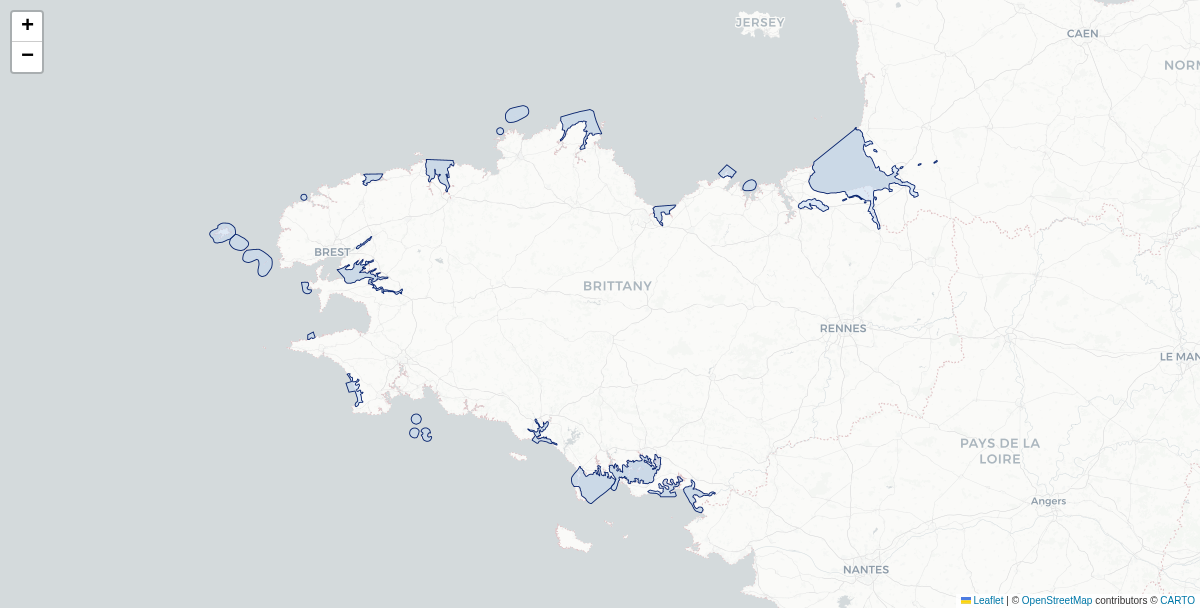

In [ ]:
from IPython.display import display
import folium
import io
import time
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo

def generate_map_from_layer(csw_url, layer_name, bbox=(-5, 47, -1, 49), zoom_start=8):
    """
    Génère une carte Folium interactive à partir d'une couche WMS obtenue via un service CSW (Catalogue Service for the Web).

    Paramètres :
    - csw_url (str) : L'URL du service CSW utilisé pour rechercher les métadonnées de la couche.
    - layer_name (str) : Le nom de la couche WMS à ajouter à la carte.
    - bbox (tuple) : Une boîte englobante définie par (longitude_min, latitude_min, longitude_max, latitude_max)
      pour centrer la carte (par défaut : (-5, 47, -1, 49)).
    - zoom_start (int) : Le niveau de zoom initial de la carte (par défaut : 8).

    Retourne :
    - folium.Map : Un objet Folium Map avec la couche WMS ajoutée si la couche est trouvée.
    - None : Si aucune couche WMS correspondante n'est trouvée ou si une erreur se produit.

    Fonctionnement :
    1. Initialise une carte Folium centrée sur la boîte englobante spécifiée.
    2. Interroge le service CSW pour rechercher une URL WMS correspondant au nom de la couche.
    3. Ajoute la couche WMS à la carte si une correspondance est trouvée.
    4. Retourne la carte Folium ou None en cas d'échec.

    Notes :
    - La couche WMS est ajoutée comme une couche raster avec des paramètres `transparent=True` et `fmt="image/png"`.
    - Nécessite les bibliothèques `folium` et `owslib` pour fonctionner.
    """

    print("Initializing Folium map...")
    brittany_map = folium.Map(location=[48.202, -3.015], zoom_start=zoom_start, tiles="cartodbpositron")
    print("Setting up CSW service...")
    csw = CatalogueServiceWeb(csw_url)
    query = PropertyIsEqualTo('csw:AnyText', layer_name)
    try:
        csw.getrecords2(constraints=[query], esn='full', maxrecords=10)
    except Exception as e:
        print(f"Error during CSW request: {e}")
        return None

    print("Searching for matching WMS layers...")
    wms_url = None
    for record_id, record in csw.records.items():
        for uri in record.uris:
            if uri['protocol'] == 'OGC:WMS' and uri['name'] == layer_name:
                wms_url = uri['url']
                print(f"Found WMS URL: {wms_url} with layer: {layer_name}")
                break
        if wms_url:
            break

    if wms_url:
        print("Adding WMS layer to the map...")
        folium.raster_layers.WmsTileLayer(
            url=wms_url,
            layers=layer_name,
            fmt="image/png",
            transparent=True,
            version="1.1.1",
            name="GeoBretagne Map Layer",
            overlay=True,
            control=True,
            show=True
        ).add_to(brittany_map)
    else:
        print("No matching WMS services found.")
    return brittany_map

def folium_map_to_image(folium_map, output_path="map.png"):
    """
    Convertit une carte Folium en image PNG en utilisant Selenium pour rendre la carte et PIL pour sauvegarder l'image.

    Paramètres :
    - folium_map (folium.Map) : L'objet Folium Map à convertir en image.
    - output_path (str) : Chemin où l'image PNG générée sera enregistrée (par défaut : "map.png").

    Retourne :
    - PIL.Image.Image : L'image générée si le processus réussit.
    - None : Si une erreur se produit lors de la capture ou de la sauvegarde de l'image.

    Fonctionnement :
    1. Sauvegarde la carte Folium dans un fichier HTML temporaire.
    2. Utilise Selenium en mode headless pour charger le fichier HTML et capturer une capture d'écran.
    3. Convertit la capture d'écran en image PNG avec PIL et l'enregistre à l'emplacement spécifié.
    4. Retourne l'image PNG générée.

    Notes :
    - Nécessite l'installation de Selenium et un WebDriver Chrome compatible.
    - Assurez-vous que le chemin du fichier HTML temporaire est accessible par le navigateur Selenium.
    - Le délai `time.sleep(3)` permet d'assurer le rendu complet de la carte avant la capture.
    """

    html_path = '/content/temp_map.html'
    print(f"Saving map to HTML at {html_path}...")
    folium_map.save(html_path)

    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--window-size=1200,800")

    try:
        print("Starting Selenium browser...")
        with webdriver.Chrome(options=options) as driver:
            driver.get(f"file://{html_path}")
            print("Waiting for the map to load...")
            time.sleep(3)
            png = driver.get_screenshot_as_png()
            print("Screenshot taken.")
    except Exception as e:
        print(f"Error occurred while capturing the map screenshot: {e}")
        return None

    try:
        image = Image.open(io.BytesIO(png))
        image.save(output_path)
        print(f"Image saved at {output_path}.")
        return image
    except Exception as e:
        print(f"Error while saving the image: {e}")
        return None


# Exemple d'utilisation
csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
layer_name = 'ZICO_region'  # Nom de la couche WMS à afficher
print("Generating map with layer name...")
map_display = generate_map_from_layer(csw_url, layer_name)

if map_display:
    print("Converting map to image...")
    map_image = folium_map_to_image(map_display)
    if map_image:
        # Afficher l'image dans un environnement Jupyter ou Colab
        display(map_image)
    else:
        print("Map image could not be generated.")
else:
    print("Map could not be generated.")


In [ ]:
import os
import gradio as gr
import html

def gradio_interface(user_input):
    """
    Gère les requêtes utilisateur pour générer des cartes, des graphiques, des tableaux ou des explications
    en utilisant des services CSW et WFS, et affiche les résultats dans une interface Gradio.

    Paramètres :
    - user_input (str) : La requête utilisateur contenant des mots-clés pour analyser et traiter les données.

    Retourne :
    - str : Une description textuelle des résultats ou des messages d'erreur.
    - str : Un tableau Markdown (si applicable) généré à partir des données.
    - gr.HTML : Une carte interactive ou un élément HTML (si applicable) pour l'affichage dans Gradio.

    Fonctionnement :
    1. Identifie si la requête concerne une carte en utilisant `is_map_request`.
    2. Si une carte est demandée :
      - Extrait les mots-clés avec `extract_keywords`.
      - Interroge le service CSW pour récupérer une couche WMS avec `get_wms_layer_and_metadata`.
      - Génère une carte avec la couche obtenue en utilisant `generate_folium_map_from_layer`.
      - Prépare la carte au format HTML pour un affichage intégré dans Gradio.
    3. Pour les requêtes non cartographiques :
      - Récupère les données via WFS avec `download_wfs_data_by_layer`.
      - Traite les données pour générer des tableaux Markdown et des explications à l'aide de LLM.
    4. Gère les erreurs et retourne les messages appropriés.

    Notes :
    - Utilise les bibliothèques `folium`, `gradio`, `owslib`, et un client Hugging Face pour le traitement des données.
    - Les cartes sont rendues au format HTML et intégrées dans l'interface Gradio.
    - Prend en charge à la fois les analyses de données tabulaires et les visualisations cartographiques.
    """

    try:
        # URL fixe pour le service CSW
        csw_url = 'https://geobretagne.fr/geonetwork/srv/fre/csw'
        #csw_url = "https://www.datagrandest.fr/geonetwork/srv/fre/csw"

        wfs_url = "https://geobretagne.fr/geoserver/wfs"
        #wfs_url = "https://www.datagrandest.fr/geoserver/wfs"

        # Vérifiez si la requête concerne une carte
        if is_map_request(user_input):
            print("Requête identifiée comme une demande de carte.")
            keywords = extract_keywords(user_input)
            print(f"Mots-clés extraits : {keywords}")

            # Récupérer les métadonnées via CSW
            layer_info = get_wms_layer_and_metadata(csw_url, keywords)

            # Vérification des métadonnées
            if layer_info["status"] != "success":
                return layer_info["formatted_text"], None, None

            # Obtenir le nom de la couche WMS
            layer_name = layer_info["layer_name"]

            # Générer une carte avec la fonction corrigée
            html_path = generate_folium_map_from_layer(
                csw_url=csw_url,
                layer_name=layer_name,
                bbox=(-5, 47, -1, 49),
                zoom_start=8
            )

            if not html_path or not os.path.exists(html_path):
                return "Erreur : Impossible de générer la carte.", None, None

            # Lire le fichier HTML généré
            with open(html_path, 'r') as file:
                html_as_string = file.read()

            # Préparer la carte pour l'affichage dans Gradio
            begin_html_iframe = '<div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe srcdoc="'
            end_html_iframe = '" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none;"></iframe></div>'
            map_html = gr.HTML(begin_html_iframe + html.escape(html_as_string) + end_html_iframe, visible=True)

            return layer_info["formatted_text"], None, map_html

        # Traitez les requêtes non cartographiques
        print("Traitement de la requête de données...")
        keywords = extract_keywords(user_input)
        layer_info = get_layer_name_and_description(csw_url, keywords)

        if layer_info["status"] != "success":
            return layer_info["formatted_text"], None, None

        # Utiliser le WFS pour récupérer les données
        type_name = layer_info["layer_name"]
        print(f"Nom de la couche utilisé pour typeName dans WFS : {type_name}")

        internal_data = download_wfs_data_by_layer(type_name, wfs_url)
        if internal_data.empty:
            return f"{layer_info['formatted_text']}\nDésolé, aucune donnée trouvée pour '{user_input}'.", None, None

        # Convertir les données en liste de dictionnaires
        filtered_json = internal_data.to_dict(orient="records")
        print("Données filtrées (aperçu) :", filtered_json[:5])

        # Générer et exécuter du code basé sur les données
        results = generate_code_with_llm(user_input, filtered_json)

        # Gestion des résultats
        if results.get("variables"):
            markdown_table = generate_markdown_table_from_dicts(results["variables"])
            explanation = generate_explanations_for_numeric_vars_v3(client, user_input, exec_env, internal_data)
            return f"{layer_info['formatted_text']}\n{explanation or ''}", markdown_table, None

        # Gestion des erreurs
        if "error" in results:
            prepared_data = results["variables"].get("prepared_json", [])
            markdown_table = generate_markdown_table_from_dicts({"prepared_json": prepared_data}) if prepared_data else None
            return f"{layer_info['formatted_text']}\nErreur lors de l'exécution : {results['error']}", markdown_table, None

        print("Aucun résultat pertinent trouvé.")
        return f"{layer_info['formatted_text']}\nAucun résultat pertinent trouvé.", None, None

    except Exception as e:
        print(f"Erreur inattendue : {e}")
        return f"Erreur inattendue : {e}", None, None


# Configuration de l'interface Gradio
gradio_ui = gr.Interface(
    fn=gradio_interface,
    inputs="text",
    outputs=["text", "markdown", "html"],
    title="Interface Gradio : Analyse et Visualisation des Données",
    description=(
        "Entrez une requête contenant des mots-clés pour générer des cartes, des graphiques, des tableaux ou des explications "
        "en fonction des données disponibles."
    )
)

# Lancer l'application Gradio
gradio_ui.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfc5dbc1d976c67a12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
